<a href="https://colab.research.google.com/github/madhugrover/Thinkful_projects/blob/master/Predicting_TeslaStockPrice_using_SVR_ARIMA_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTS
%tensorflow_version 1.x
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.models import Sequential
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

TensorFlow 1.x selected.


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# Getting our stock data for ARIMA Model

In [0]:
# get 2014-today data for our arima model
start = datetime.datetime(2014,1,1)
end = datetime.datetime.today()
dfa = web.DataReader("TSLA", 'yahoo', start, end) 

In [3]:
dfa = dfa.reset_index()
dfa.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2014-01-02,152.479996,146.550003,149.800003,150.100006,6188400,150.100006
1,2014-01-03,152.190002,148.600006,150.000000,149.559998,4695000,149.559998
2,2014-01-06,150.399994,145.240005,150.000000,147.000000,5361100,147.000000
3,2014-01-07,150.399994,145.250000,147.619995,149.360001,5034100,149.360001
4,2014-01-08,153.699997,148.759995,148.850006,151.279999,6163200,151.279999


In [4]:
dfa.shape

(1599, 7)

# Creating ARIMA Model

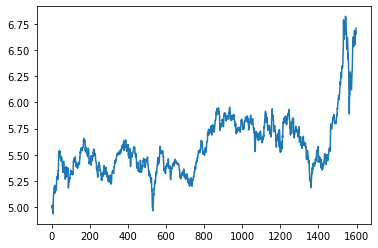

In [5]:
dfa['adj_close_log'] = np.log(dfa['Adj Close'])
plt.plot(dfa.index, dfa['adj_close_log'])
plt.show()

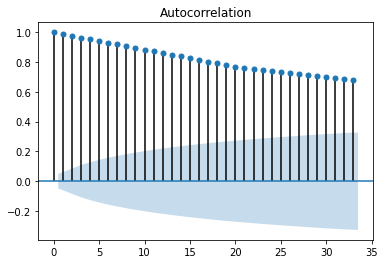

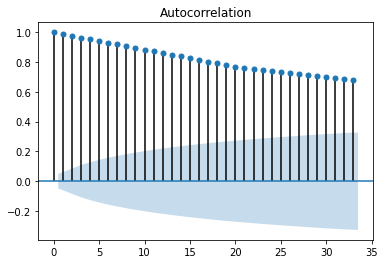

In [6]:
#ACF Plot
plot_acf(dfa['adj_close_log'])

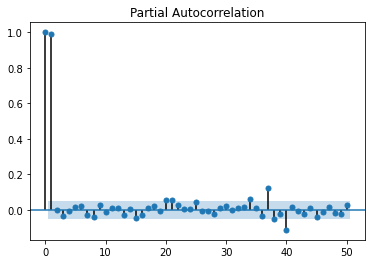

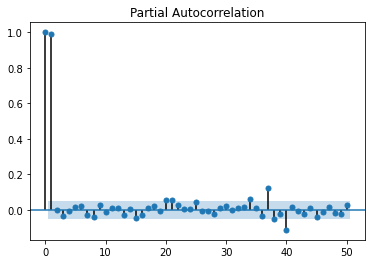

In [7]:
#PACF Plot
plot_pacf(dfa['adj_close_log'], lags=50)

In [8]:
model = ARIMA(dfa['adj_close_log'], order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
predictions = model_fit.predict(1599, 1619, typ='levels')
predictions_adj = np.exp(predictions)

                             ARIMA Model Results                              
Dep. Variable:        D.adj_close_log   No. Observations:                 1598
Model:                 ARIMA(5, 1, 0)   Log Likelihood                3217.759
Method:                       css-mle   S.D. of innovations              0.032
Date:                Sun, 10 May 2020   AIC                          -6421.518
Time:                        03:13:03   BIC                          -6383.883
Sample:                             1   HQIC                         -6407.542
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0011      0.001      1.282      0.200      -0.001       0.003
ar.L1.D.adj_close_log     0.0161      0.025      0.642      0.521      -0.033       0.065
ar.L2.D.

# 20 day stock price prediction of ARIMA Model

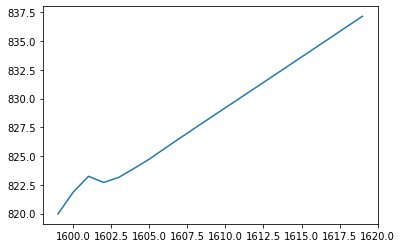

In [9]:
plt.plot(predictions_adj)
plt.show()

In [10]:
predictions_adj

1599    819.964543
1600    821.862947
1601    823.236141
1602    822.697167
1603    823.148625
1604    823.926269
1605    824.731809
1606    825.644315
1607    826.549046
1608    827.435962
1609    828.319841
1610    829.199335
1611    830.078386
1612    830.958879
1613    831.840549
1614    832.723409
1615    833.607339
1616    834.492221
1617    835.378036
1618    836.264782
1619    837.152460
dtype: float64

# Getting our Stock data for LSTM model

In [0]:
# Get the stock data using yahoo API:
style.use('ggplot')

# get 2014-2019 data to train our model
start = datetime.datetime(2010,6,28)
end = datetime.datetime(2020,3,8)
df = web.DataReader("TSLA", 'yahoo', start, end) 

# get 2019 data to test our model on 
start = datetime.datetime(2020,1,13)
end = datetime.date.today()
test_df = web.DataReader("TSLA",  'yahoo', start, end) 

In [0]:
# sort by date
df = df.sort_values('Date')
test_df = test_df.sort_values('Date')

In [0]:
# fix the date 
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)
test_df.reset_index(inplace=True)
test_df.set_index("Date", inplace=True)

# Visualize the training stock data

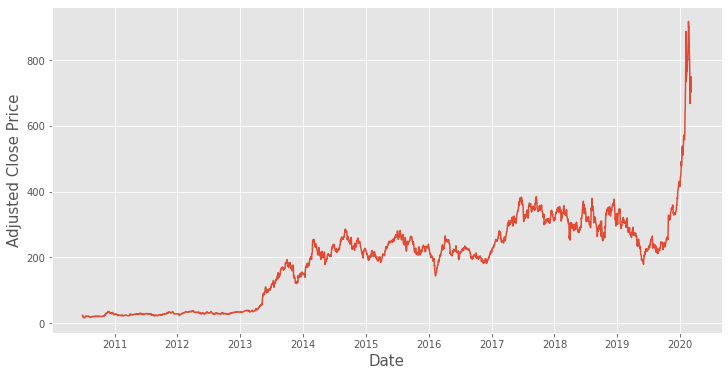

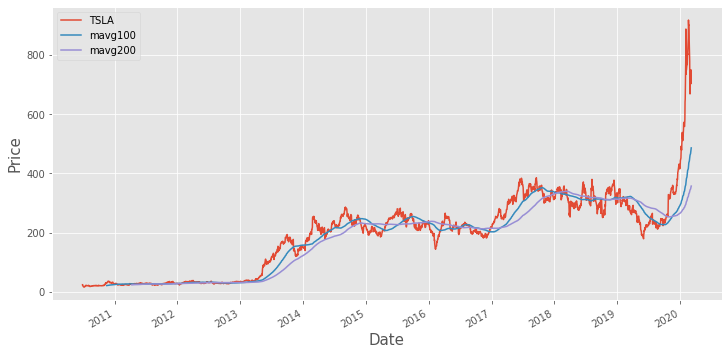

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,6))
plt.plot(df["Adj Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('Adjusted Close Price',fontsize=15)
plt.show()


# Rolling mean
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
mavg2 = close_px.rolling(window=200).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='TSLA')
mavg.plot(label='mavg100')
mavg2.plot(label='mavg200')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.legend();

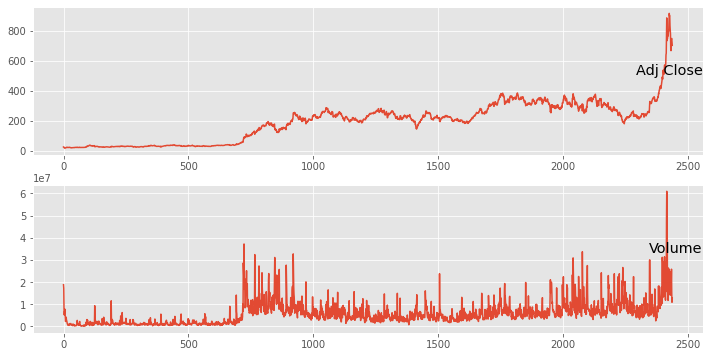

In [15]:
from matplotlib import pyplot
values = df.values
# specify columns to plot
groups = [5, 4]
i = 1
# plot each column
pyplot.figure(figsize = (12,6))
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

# Converting Dates

In [16]:
import matplotlib.dates as mdates

# change the dates into ints for training 
dates_df = df.copy()
dates_df = dates_df.reset_index()

# Store the original dates for plotting the predicitons
org_dates = dates_df['Date']

# convert to ints
dates_df['Date'] = dates_df['Date'].map(mdates.date2num)

dates_df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
2434,737486.0,743.690002,686.669983,711.260010,743.619995,20195000,743.619995
2435,737487.0,806.979980,716.109985,805.000000,745.510010,25784000,745.510010
2436,737488.0,766.520020,724.729980,763.960022,749.500000,15049000,749.500000
2437,737489.0,745.750000,718.070007,723.770020,724.539978,10852700,724.539978
2438,737490.0,707.000000,684.270020,690.000000,703.479980,12662900,703.479980


In [17]:
# Create train set of adj close prices data:
train_data = df.loc[:,'Adj Close'].to_numpy()
print(train_data.shape) 

(2439,)


In [18]:
print(train_data.max())
print(train_data.min())
print(train_data.mean())
print(train_data.std())

917.4199829101562
15.800000190734863
192.04155811084593
132.0499644825633


# SVR code using sklearn and viusalizing kernels

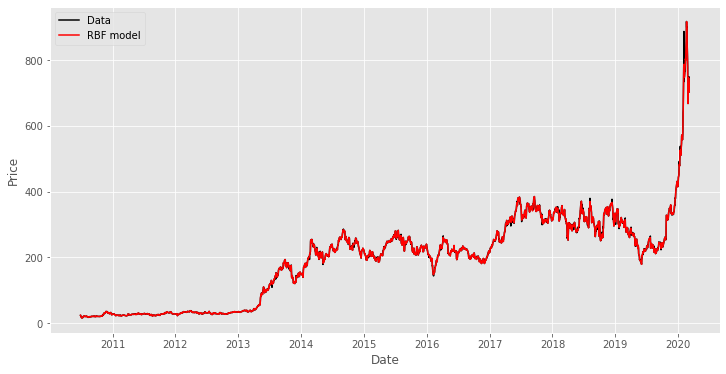

In [19]:
# Use sklearn support vector regression to predicit our data:
from sklearn.svm import SVR

dates = dates_df['Date'].to_numpy()
prices = df['Adj Close'].to_numpy()

#Convert to 1d Vector
dates = np.reshape(dates, (len(dates), 1))
prices = np.reshape(prices, (len(prices), 1))

svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(dates, prices)

plt.figure(figsize = (12,6))
plt.plot(dates, prices, color= 'black', label= 'Data')
plt.plot(org_dates, svr_rbf.predict(dates), color= 'red', label= 'RBF model') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In this code we use Sklearn and Support Vector Regression (SVR) to predict the prices on our data.
As you can see in fits the data extremely well, but it is most likely overfit. This model would have a hard time generalizing on a year of unseen Tesla stock data. That is where our LSTM neural network comes in handy.

# Apply normalization before feeding to LSTM using sklearn

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)
print(train_data.shape)

(2439, 1)


In [21]:
print(train_data.max())
print(train_data.min())
print(train_data.mean())
print(train_data.std())

1.0
0.0
0.19547210720478936
0.1464585601622102


In [22]:
train_data.shape

(2439, 1)

# Preparing our data for the neural network

In [0]:
# Function to create a dataset to feed into an LSTM
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [24]:
# Create the data to train our model on:
look_back = 36
X_train, y_train = create_dataset(train_data, look_back)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)

(2403, 36, 1)


In [25]:
X_train.mean()

0.19205020405159756

# Creating the LSTM model using KERAS

In [26]:
model = keras.Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
history = model.fit(X_train,y_train,epochs=100,batch_size=32)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/100
2403/2403 [==============================] - 7s 3ms/step - loss: 0.0055
Epoch 2/100
2403/2403 [==============================] - 6s 3ms/step - loss: 0.0019
Epoch 3/100
2403/2403 [==============================] - 6s 3ms/step - loss: 0.0017
Epoch 4/100
2403/2403 [==============================] - 6s 3ms/step - loss: 0.0017
Epoch 5/100
2403/2403 [==============================] - 6s 3ms/step - loss: 0.0015
Epoch 6/100
2403/2403 [==============================] - 6s 3ms/step - loss: 0.0012
Epoch 7/100
2403/2403 [==============================] - 6s 3ms/step - loss: 0.0011
Epoch 8/100
2403/2403 [==============================] - 6s 3ms/step - loss: 0.0013
Epoch 9/100
2403/2403 [==============================] - 6s 3ms/step - loss: 0.0011
Epoch 10/100
2403/2403 [==============================] - 6s 3ms/step - loss: 9.2592e-04
Epoch 11/100
2403/2403 [==============================] - 6s 3ms/step - l

# Plot training & validation loss values

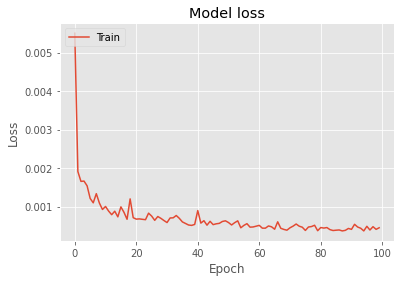

In [27]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Get the test data to have our model make the predictions

In [0]:
test_data = test_df['Adj Close'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

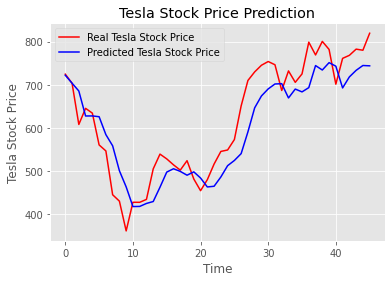

In [29]:
# Create the data to test our model on:
time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)


# plot the results 
plt.plot(org_y, color = 'red', label = 'Real Tesla Stock Price')
plt.plot(predicted_y, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

In [0]:
org_y = list(org_y)
data = pd.DataFrame(org_y,columns =['data'])
data.reset_index(inplace=True)
predicted_y = list(predicted_y)
prediction = pd.DataFrame(predicted_y,columns=['prediction'])
prediction.reset_index(inplace=True)

In [31]:
result = pd.merge(data, prediction, on='index')
error = result['prediction'] - result['data']
result['error'] =error
result

,index,data,prediction,error
0,0,724.539978,722.026306,-2.513672
1,1,703.479980,703.669739,0.189758
2,2,608.000000,685.557068,77.557068
3,3,645.330017,627.617798,-17.712219
4,4,634.229980,627.768250,-6.461731
5,5,560.549988,625.942566,65.392578
6,6,546.619995,584.438782,37.818787
7,7,445.070007,558.484253,113.414246
8,8,430.200012,500.661041,70.461029
9,9,361.220001,463.217987,101.997986


# Getting data for forecasting, 20 days, with LSTM

In [0]:
start = datetime.datetime(2010,6,28)
end = datetime.date.today()
df_full = web.DataReader("TSLA", 'yahoo', start, end) 

In [0]:
df_full.drop(columns=['Open', 'High', 'Low', 'Volume','Close'], inplace=True)

In [0]:
## change the dates into ints for training 
df = df_full.copy()
df = df.reset_index()

In [0]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_axis(df['Date'], inplace=True)

In [0]:
close_data = df['Adj Close'].values
close_data = close_data.reshape((-1,1))
scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [0]:
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 20
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)
forecast = forecast.reshape((-1,1))
forecast = scaler.inverse_transform(forecast)

In [38]:
forecast.mean()

647.148720174499

In [39]:
close_data.mean()

0.20383941589626484

In [0]:
dates = list(forecast_dates)
dates = pd.DataFrame(forecast_dates,columns =['dates'])
dates.reset_index(inplace=True)
forecast = list(forecast)
forecast = pd.DataFrame(forecast,columns=['forecast_lstm'])
forecast.reset_index(inplace=True)

In [46]:
forecast_result = pd.merge(dates, forecast, on='index')
forecast_result

,index,dates,forecast_lstm
0,0,2020-05-08,819.419983
1,1,2020-05-09,769.511873
2,2,2020-05-10,740.793629
3,3,2020-05-11,717.566989
4,4,2020-05-12,699.801644
5,5,2020-05-13,686.113663
6,6,2020-05-14,674.785169
7,7,2020-05-15,664.537347
8,8,2020-05-16,654.678663
9,9,2020-05-17,644.951858


In [59]:
forecast_arima = list(predictions_adj)
forecast_arima = pd.DataFrame(forecast_arima,columns=['forecast_arima'])
forecast_compare = pd.concat([forecast_arima, forecast], axis=1, sort=False)
forecast_compare

,forecast_arima,forecast_lstm
0,819.964543,819.419983
1,821.862947,769.511873
2,823.236141,740.793629
3,822.697167,717.566989
4,823.148625,699.801644
5,823.926269,686.113663
6,824.731809,674.785169
7,825.644315,664.537347
8,826.549046,654.678663
9,827.435962,644.951858


# Conclusion

ARIMA model seems to give us one directional data predictions of higher stock prices.
SVR seems to be overfitting our data
LSTM model gave us a more neutral to downward prediction of the stock price.LSTMs are very fascinating and they have so many useful applications. They allow for accurate predictions on long series of sequential data.
We can further compare the prediction with real data next week and see whcih model performed better.